# Find Similar Publications in Neptune Analytics using Vector Similarity Search

This notebook provides a code example for the blog post on finding and linking similar entitiesin Amazon Neptune. In this notebook we explore the DBLP/ACM publication dataset (https://doi.org/10.3886/E100843V2) linking publications and authors. Our goal is to find similar publications using semantic search.

Semantic search differs from lexical search. Lexical search is the ability is find entities with similar text content. For example, patients with names “Walter A. Phillips” and “Philip Allan Walters” having the same date of birth and the same zip code could be resolved to the same patient entity because of their close lexical similarity. Try out the notebook FindAndLink-FTS to experiment with lexical search in Neptune. 

Semantic search is the ability to find entities with similar meaning. This approach uses a machine learning model to create a numeric vector embedding of the entity. Each term in the vector encodes some aspect of the entity’s meaning. The goal of the model is to create similar vectors for similar entities! Vector databases enable us to store vectors and run queries to determine vector distance. A vector database can help us resolve two entities whose vector embeddings have a small distance separating them. 

This notebook uses vector similarity search in Neptune Analytics to find publications that are semantically similar. The graph has two types of nodes -- Publication and Author -- with publications linked to author via the hasAuthor edge. Each publication node has an embedding that is sentence vectorization of the title.  Consider the two publications shown:

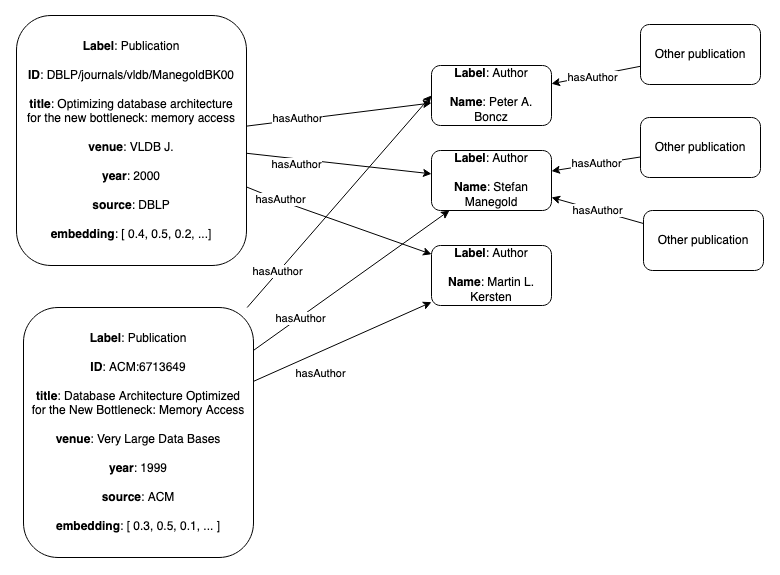

Their titles are similar. We can measure how similar by having Neptune compute vector similarity of their embeddings. As a further check, we verify their authors. These publications have the same authors, and are thus likely duplicates.

Here is another example. 

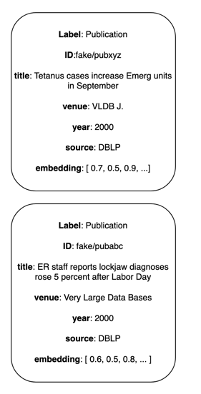

The titles are not lexically similar, but they do in fact mean the same.  Tetanus and lockjaw refer to the same disease; “emerge” and “ER” are synonymous. We'll check whether their embeddings are similar. As an additional check, we compare authors, requiring signficantly overlap before matching the publications.

We prepared the dataset, including the embeddings ahead of time. If you are interested to explore how the data is prepared, see FindAndLink-DataPrep.ipynb. 

## Setup
This notebook requires a Neptune Analytics graph, along with a notebook instance. 

Follow instructions in https://docs.aws.amazon.com/neptune-analytics/latest/userguide/create-graph-using-console.html to create a graph. Ensure you configure the graph to have vector dimension of 384. Follow instructions in https://docs.aws.amazon.com/neptune-analytics/latest/userguide/notebooks.html to create a notebook instance to access the graph. 

When setup is complete, access Jupyter in the notebook instance, upload this notebook, and run through the steps below. 


## Setup text-to-vector mapping
For embeddings, we will use all-MiniLM-L6-v2 from HuggingFace.
The data we will load into Neptune already has the embeddings.
But we need to vectorize input the same way.

In [ ]:
pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# sentences - one or list of text sentences
def get_embeddings(sentences):
    embeddings = model.encode(sentences)
    return embeddings
    
# convert embedding to semi-colon sep list for Neptune load format
def get_str_embedding(embedding):
    return ';'.join([str(x) for x in embedding])
    

### Inspect a few rows of the publications file we will load
Download a local copy of the bulk load publication CSV file for inspection. Notice that rows end with embeddings as comma-separated list.

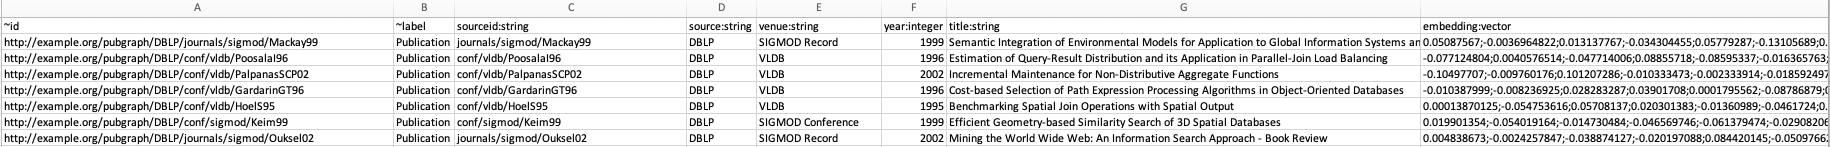

In [ ]:
%%bash

aws s3 cp s3://aws-neptune-customer-samples/neptune-ent-res/publications/vss/pg/nodes/pub.csv .
head -3 pub.csv
rm pub.csv

## Load to Neptune
Call Neptune load function to load publication and author nodes and edges linking those nodes. Included is ingest of the publication embeddings.

In [ ]:
import graph_notebook as gn
config = gn.configuration.get_config.get_config()

region = config.aws_region
s3_bucket = "s3://aws-neptune-customer-samples/neptune-ent-res/publications/vss/pg/"


In [ ]:
%%oc

CALL neptune.load({format: "csv", 
                   source: "${s3_bucket}", 
                   region : "${region}"})



## Explore data

We'll run OpenCypher queries against Neptune database. 

### Look at publications
Notice we can't see the embedding. It's not a property of the node. 

In [ ]:
%%oc

MATCH(p:Publication)
RETURN p
LIMIT 10

### Publication with embeddings

In [ ]:
%%oc

MATCH (p:Publication)
CALL neptune.algo.vectors.get(p)
YIELD embedding
RETURN id(p), embedding
LIMIT 10

### Look at author nodes

In [ ]:
%%oc

MATCH(a:Author)
RETURN a
LIMIT 10

### Look at relationship between publications and authors
Try the graph view

In [ ]:
%%oc --d id

MATCH p=(n:Publication)-[:hasAuthor]->(a:Author)
RETURN p
LIMIT 200

## Look at embeddings for a few special cases
The cases:

- Fake publication:DBLP/journals/haveyweb/1 is similar to actual publication:ACM/604282 and publication:DBLP/journals/sigmod/ShahMFH01

- Fake publication:DBLP/journals/haveyweb/2 and publication:DBLP/journals/haveyweb/3 are similar, in purely a semantic way, to each other.

Note: the haveyweb publications are mock publications. We added them to the dataset for testing purposes.


In [ ]:
params={
    'haveyjava':'http://example.org/pubgraph/DBLP/journals/haveyweb/1',
    'acmjava': 'http://example.org/pubgraph/ACM/604282',
    'dblpjava': 'http://example.org/pubgraph/DBLP/journals/sigmod/ShahMFH01',
    'haveytetanus': 'http://example.org/pubgraph/DBLP/journals/haveyweb/2',
    'haveylockjaw': 'http://example.org/pubgraph/DBLP/journals/haveyweb/3'
}

In [ ]:
%%oc -qp params

MATCH (p:Publication)
WHERE id(p) in [$haveyjava, $acmjava, $dblpjava, $haveytetanus, $haveylockjaw] 
CALL neptune.algo.vectors.get(p)
YIELD embedding
RETURN id(p), p.title, embedding
ORDER by id(p)


## Look at some vector distances
Should be a bit close

In [ ]:
%%oc -qp params

MATCH (p:Publication) WHERE id(p)= $haveyjava
MATCH (q:Publication) WHERE id(q) = $dblpjava
CALL neptune.algo.vectors.distance(p, q)
YIELD distance
RETURN distance, p.title, q.title

Should be REALLY close

In [ ]:
%%oc -qp params

MATCH (p:Publication) WHERE id(p)= $acmjava
MATCH (q:Publication) WHERE id(q) = $dblpjava
CALL neptune.algo.vectors.distance(p, q)
YIELD distance
RETURN distance, p.title, q.title

These are different publications entirely. Not nearly as close.

In [ ]:
%%oc -qp params

MATCH (p:Publication) WHERE id(p)= $haveyjava
MATCH (q:Publication) WHERE id(q) = $haveylockjaw
CALL neptune.algo.vectors.distance(p, q)
YIELD distance
RETURN distance, p.title, q.title

## Check similar publications


In [ ]:
%%oc -qp params

MATCH(p)
MATCH (p)-[:hasAuthor]->(pa:Author)
WHERE id(p)=$haveyjava

CALL neptune.algo.vectors.topKByNode(p)
YIELD node, score
WITH id(p) as candidate, p.title as candidateTitle, collect(pa.name) as candidateAuthors, node, score

MATCH (node)-[:hasAuthor]->(na:Author)

RETURN candidate, id(node) as matched, candidateTitle, node.title as matchedTitle, score, 
    candidateAuthors, collect(na.name) as matchedAuthors

ORDER by score


### Create a match

The last result makes us see that http://example.org/pubgraph/ACM/604282 and http://example.org/pubgraph/DBLP/journals/sigmod/ShahMFH01 are the same publication. Same score, same authors.

Let's materialize a match

In [ ]:
%%oc

MATCH(p1)
WHERE id(p1)='http://example.org/pubgraph/ACM/604282'

MATCH(p2)
WHERE id(p2)='http://example.org/pubgraph/DBLP/journals/sigmod/ShahMFH01'

CREATE (p1)-[e:matches {matchSource: "user", matchAlg: "vss"}]->(p2)

RETURN e


In [ ]:
%%oc

MATCH(a)-[m:matches]->(b)
RETURN a, m, b
LIMIT 100

## Search embeddings
Now, rather than compare nodes to each other, we'll compare a search term to nodes. 

In [ ]:
embparams={'emb': get_embeddings('Tetanus cases September').tolist()}

In [ ]:
%%oc -qp embparams

WITH $emb as emb
CALL neptune.algo.vectors.topKByEmbedding(emb)
YIELD embedding, node, score
WITH node, score, embedding

MATCH (node)-[:hasAuthor]->(a:Author)

RETURN id(node) as matched, node.title as matchedTitle, score, collect(a.name) as authors
ORDER by score